## Required Libraries

In [1]:
import pandas as pd
import numpy as np


## Data Preprocessing

In [3]:
# Read only the first two columns
#df = pd.read_csv("Waste_3_6.csv", usecols=[0, 1])

df = pd.read_csv("Waste_3_6_July_Nov.csv", usecols=[0, 1])  ### new data set

# Rename columns
df.columns = ["Datetime", "Flow[cfs]"]

# Convert to datetime (auto-detects all formats)
df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")

# Convert flow values to numeric
df["Flow[cfs]"] = pd.to_numeric(df["Flow[cfs]"], errors="coerce")

# Drop invalid rows and set datetime index
df = df.dropna(subset=["Datetime"]).set_index("Datetime")

# Count how many have missing flow values
missing_points = df["Flow[cfs]"].isna().sum()

# Display first few rows
print(df.head())
print("Missing point",missing_points)


                     Flow[cfs]
Datetime                      
2025-07-18 17:08:00    0.45576
2025-07-18 17:18:00    0.47959
2025-07-18 17:28:00    0.47959
2025-07-18 17:38:00    0.44781
2025-07-18 17:48:00    0.40810
Missing point 0


### Resample into 10 min flow 

In [9]:
# Resample to a strict 10-minute grid and compute the mean per bin
flow_10min = df.resample("10min").mean()

### detecting and handliing outliers if any

In [11]:
# Compute quartiles
Q1 = flow_10min["Flow[cfs]"].quantile(0.25)
Q3 = flow_10min["Flow[cfs]"].quantile(0.75)
IQR = Q3 - Q1

# Bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = flow_10min[
    (flow_10min["Flow[cfs]"] < lower_bound) | 
    (flow_10min["Flow[cfs]"] > upper_bound)
]

print(f"Total outliers detected: {len(outliers)}")
print(f"Lower bound: {lower_bound:.3f}, Upper bound: {upper_bound:.3f}")

Total outliers detected: 0
Lower bound: 0.131, Upper bound: 1.018


In [13]:
flow_10min.loc[
    (flow_10min["Flow[cfs]"] < lower_bound) | 
    (flow_10min["Flow[cfs]"] > upper_bound), 
    "Flow[cfs]"
] = None

### Interpolate missing and outlier gaps (time-based)

In [15]:
# fill gaps smoothly if there are any using time-based interpolation
flow_10min = flow_10min.interpolate(method="time")

# Display first few rows
print(flow_10min.head())

                     Flow[cfs]
Datetime                      
2025-07-18 17:00:00    0.45576
2025-07-18 17:10:00    0.47959
2025-07-18 17:20:00    0.47959
2025-07-18 17:30:00    0.44781
2025-07-18 17:40:00    0.40810


# ML Models

In [17]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor


In [18]:
# Expectation: `flow_10min` exists with DatetimeIndex (10-min) and a column "Flow[cfs]"
df = flow_10min.copy().sort_index()

###  Feature engineering

In [21]:
def add_lags_24h_fast(frame, col="Flow[cfs]"):
    s = frame[col]
    # Build a dict of shifted Series, then concat once
    lag_dict = {f"lag_{L}": s.shift(L) for L in range(1, 145)}
    lag_df = pd.DataFrame(lag_dict, index=frame.index)
    return pd.concat([frame, lag_df], axis=1)

def add_cyclic_time_features(frame):
    idx = frame.index
    day_pos = (idx.hour * 60 + idx.minute) / (24 * 60)
    dow = idx.dayofweek / 7.0
    # create all four at once, then concat once
    cyc = pd.DataFrame({
        "hour_sin": np.sin(2*np.pi*day_pos),
        "hour_cos": np.cos(2*np.pi*day_pos),
        "dow_sin":  np.sin(2*np.pi*dow),
        "dow_cos":  np.cos(2*np.pi*dow),
    }, index=frame.index)
    return pd.concat([frame, cyc], axis=1)

def make_supervised(series_col="Flow[cfs]", horizon_steps=36):
    frame = df[[series_col]].copy()
    frame = add_cyclic_time_features(frame)
    frame = add_lags_24h_fast(frame, col=series_col)

    # Build all future targets at once, then concat once
    y_dict = {f"y_t+{h}": frame[series_col].shift(-h)
              for h in range(1, horizon_steps+1)}
    y_df = pd.DataFrame(y_dict, index=frame.index)

    frame = pd.concat([frame, y_df], axis=1).dropna()

    feature_cols = [c for c in frame.columns
                    if c not in [series_col] and not c.startswith("y_t+")]
    target_cols  = [f"y_t+{h}" for h in range(1, horizon_steps+1)]

    X = frame[feature_cols].values
    Y = frame[target_cols].values
    t_index = frame.index
    return X, Y, t_index, feature_cols, target_cols


In [23]:
H = 18  # 3 hours ahead @ 10-min
X, Y, t_idx, feature_cols, target_cols = make_supervised("Flow[cfs]", H)

In [25]:
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)
print("Number of samples:", X.shape[0])
print("Number of features per sample:", X.shape[1])
print("Number of prediction steps:", Y.shape[1])
print("Date range covered:", t_idx[0], "→", t_idx[-1])

Shape of X: (16816, 148)
Shape of Y: (16816, 18)
Number of samples: 16816
Number of features per sample: 148
Number of prediction steps: 18
Date range covered: 2025-07-19 17:00:00 → 2025-11-13 11:30:00


### Chronological 70:15:15 split

In [27]:
N = len(X)
i_train = int(0.70 * N)
i_valid = int(0.85 * N)

X_train, Y_train = X[:i_train],       Y[:i_train]
X_valid, Y_valid = X[i_train:i_valid], Y[i_train:i_valid]
X_test,  Y_test  = X[i_valid:],        Y[i_valid:]
t_train, t_valid, t_test = t_idx[:i_train], t_idx[i_train:i_valid], t_idx[i_valid:]

print(f"Samples -> train: {len(X_train)}, valid: {len(X_valid)}, test: {len(X_test)}")


Samples -> train: 11771, valid: 2522, test: 2523


### Train one model per horizon step

In [69]:
#!pip install -U xgboost

In [29]:
import xgboost as xgb
from xgboost import XGBRegressor
from packaging import version

In [31]:
# --- Step 1: Define hyperparameters
xgb_params = dict(
    objective="reg:squarederror",
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)


In [33]:
import xgboost as xgb
from xgboost import XGBRegressor
import inspect

fit_params = list(inspect.signature(XGBRegressor.fit).parameters.keys())
supports_callbacks = "callbacks" in fit_params
supports_esr = "early_stopping_rounds" in fit_params

models, best_rounds = [], []

for h in range(H):
    y_tr = Y_train[:, h]
    y_va = Y_valid[:, h]

    model = XGBRegressor(eval_metric="rmse", **xgb_params)

    if supports_callbacks:
        model.fit(
            X_train, y_tr,
            eval_set=[(X_valid, y_va)],
            callbacks=[xgb.callback.EarlyStopping(rounds=100, save_best=True)]
        )
    elif supports_esr:
        model.fit(
            X_train, y_tr,
            eval_set=[(X_valid, y_va)],
            early_stopping_rounds=100,
            verbose=False
        )
    else:
        model.fit(X_train, y_tr)

    best_iter = None
    for attr in ("best_iteration", "best_ntree_limit", "best_score"):
        if hasattr(model, attr):
            best_iter = getattr(model, attr)
            break
    best_rounds.append(best_iter or model.get_params().get("n_estimators"))
    models.append(model)

print("Detected fit() supports:", {"callbacks": supports_callbacks, "early_stopping_rounds": supports_esr})
print("Best rounds (first 10):", best_rounds[:10])

Detected fit() supports: {'callbacks': False, 'early_stopping_rounds': False}
Best rounds (first 10): [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]


In [39]:
import joblib

# Save the list of 18 trained XGBoost models
joblib.dump(models, "xgboost_models.joblib")

print("Successfully saved xgboost_models.joblib")

Successfully saved xgboost_models.joblib


In [ ]:
### Evaluate on test

In [35]:
Y_pred_test = np.column_stack([m.predict(X_test) for m in models])

mae_per_h  = [mean_absolute_error(Y_test[:, h], Y_pred_test[:, h]) for h in range(H)]
rmse_per_h = [sqrt(mean_squared_error(Y_test[:, h], Y_pred_test[:, h])) for h in range(H)]

mae_overall  = mean_absolute_error(Y_test.ravel(), Y_pred_test.ravel())
rmse_overall = sqrt(mean_squared_error(Y_test.ravel(), Y_pred_test.ravel()))

print(f"Overall MAE:  {mae_overall:.4f} cfs")
print(f"Overall RMSE: {rmse_overall:.4f} cfs")



Overall MAE:  0.0451 cfs
Overall RMSE: 0.0568 cfs


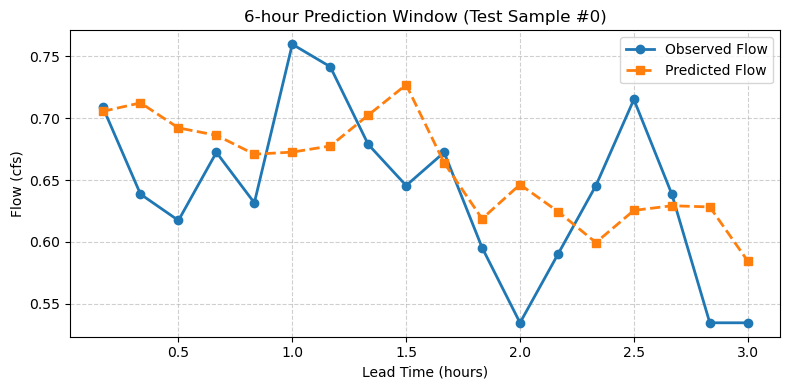

In [37]:
import matplotlib.pyplot as plt

# choose which test sample to plot
sample_id = 0    # you can change this to any index within range(len(Y_test))

# actual vs predicted 6-hour flow sequence
y_true = Y_test[sample_id, :]
y_pred = Y_pred_test[sample_id, :]

# time axis in hours
time_steps = np.arange(1, H + 1) * 10 / 60  # 10-min steps → hours

plt.figure(figsize=(8, 4))
plt.plot(time_steps, y_true, 'o-', label='Observed Flow', linewidth=2)
plt.plot(time_steps, y_pred, 's--', label='Predicted Flow', linewidth=2)
plt.xlabel('Lead Time (hours)')
plt.ylabel('Flow (cfs)')
plt.title(f'6-hour Prediction Window (Test Sample #{sample_id})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [35]:
# Quick per-lead summary
summary = pd.DataFrame({
    "horizon_step": np.arange(1, H + 1),
    "lead_time_min": np.arange(1, H + 1) * 10,
    "lead_time_hr":  np.arange(1, H + 1) * 10 / 60,
    "MAE_cfs": mae_per_h,
    "RMSE_cfs": rmse_per_h,
})
summary.head(10)

,horizon_step,lead_time_min,lead_time_hr,MAE_cfs,RMSE_cfs
0,1,10,0.166667,0.054694,0.067800
1,2,20,0.333333,0.056395,0.069703
2,3,30,0.500000,0.056656,0.070235
3,4,40,0.666667,0.058268,0.071823
4,5,50,0.833333,0.058407,0.072331
5,6,60,1.000000,0.058266,0.072096
6,7,70,1.166667,0.058546,0.072133
7,8,80,1.333333,0.058992,0.072833
8,9,90,1.500000,0.058666,0.072580
9,10,100,1.666667,0.059094,0.073314
